In [ ]:
#インポート

import pickle
from google.colab import files
from PIL import Image
import numpy as np
from scipy import signal
import random

In [ ]:
#学習済みモデルを読み込み

with open('/content/drive/MyDrive/アルバイト/PreApp/model.sav', mode='rb') as f:
    model = pickle.load(f)

In [ ]:
#画像ファイルの読み込み

uploaded = files.upload()
file_name = next(iter(uploaded))

Saving jacket-coordinate-oj2057-tp2061-bl2058-as1606-02_staff.jpg to jacket-coordinate-oj2057-tp2061-bl2058-as1606-02_staff.jpg


In [ ]:
#画像処理
img_color = Image.open("/content/" + file_name)
img_gray = img_color.convert("L") #グレースケール変換

#numpy配列に変換
img_color_np = np.asarray(img_color, dtype = "float32")
img_gray_np = np.asarray(img_gray, dtype = "float32")

#サイズを取得
img_h, img_w = img_gray_np.shape

In [ ]:
#カーネルを作成
kernel_v = np.zeros((3,3))
kernel_v[1,1] = -1
kernel_v[2,1] = 1

#微分
img_v = signal.convolve2d(img_gray_np, kernel_v, mode="same")
img_v = np.clip(img_v, 0, 255).astype("uint8")

In [ ]:
#上半身と下半身の境目を検出

ave_color = (np.average(img_v) + np.max(img_v)) / 2

line = np.where(img_v > ave_color)[0]

k = img_h // 10
count_list = []

for y in range(0, img_h, k):
    count_list.append(np.count_nonzero((line > y) & (y + k > line)))

count_list.sort(reverse=True)
count_list = list(map(lambda x: count_list.index(x) * k + (k // 2), count_list))


edge = count_list[np.abs(np.asarray(count_list) - (img_h / 2)).argmin()]
img_color_np[edge, 0:] = 0

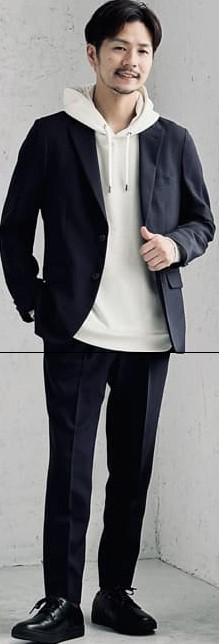

In [ ]:
#境目を表示

display(Image.fromarray(img_color_np.astype(np.uint8)))

In [ ]:
#無駄なところを塗りつぶし

def delete(row):
    for index, color in enumerate(row):
        if (np.average(color) > 200):
            row[index] = 0

    return row

color_img = np.array([*map(delete, img_color_np)])

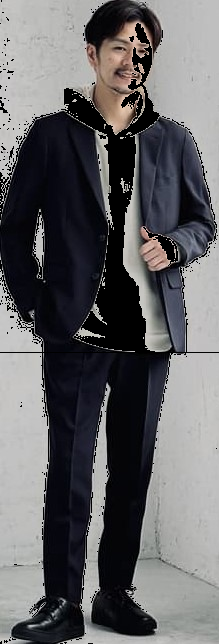

In [ ]:
display(Image.fromarray(img_color_np.astype(np.uint8)))

In [ ]:
def conversion_color(cloth, pants):
    color = np.zeros((300, 150, 3))
    color[0:300, 0:150] = cloth
    color[150:300, 0:150] = pants


    display(Image.fromarray(color.astype(np.uint8)))




In [ ]:
#判定

kernel_size = 10
output_size = (img_h // kernel_size) * (img_w // kernel_size)

output = []

for y in range(0, edge, kernel_size):
    for x in range(img_w // 4, (img_w // 4) * 3, kernel_size):
        kernel_1_on_color_ave = []
        kernel_2_on_color_ave = []

        kernel_1 = img_color_np[y:y + kernel_size, x:x + kernel_size]

        kernel_1_on_color = []
        for row in kernel_1:
            for color in row:
                if(np.average(color) > 0):
                    kernel_1_on_color.append(color)

        kernel_1_on_color = np.array(kernel_1_on_color)
        if(len(kernel_1_on_color) != 0):
            kernel_1_on_color_ave = np.mean(kernel_1_on_color, axis=0)

        kernel_2 = img_color_np[edge + y:edge + y + kernel_size, x:x + kernel_size]

        kernel_2_on_color = []
        for row in kernel_2:
            for color in row:
                if(np.average(color) > 0):
                    kernel_2_on_color.append(color)

        kernel_2_on_color = np.array(kernel_2_on_color)
        if(len(kernel_2_on_color) != 0):
            kernel_2_on_color_ave = np.mean(kernel_2_on_color, axis=0)

        if(len(kernel_1_on_color_ave) != 0 and len(kernel_2_on_color_ave) != 0):
            color_1 = kernel_1_on_color_ave / 255
            color_2 = kernel_2_on_color_ave / 255


            input = np.concatenate([color_1,color_2])

            #conversion_color(kernel_1_on_color_ave, kernel_2_on_color_ave)

            predict = model.predict([input])[0]
            #print(predict)
            output.append(predict)

output = np.array(output)

In [ ]:
ave = np.average(output)
judge = (ave >= 0.5).astype(int)

print(f'この配色は {ave * 100}%　適格です')

この配色は 66.85393258426966%　適格です
